1. Импорт библиотек. Импортированы все необходимые библиотеки.
2. Предварительная обработка данных. Загрузка датасета, обработка пропущенных значений и кодирование категориальных признаков.
3. Разделение на обучающую и тестовую выборки. Использование `train_test_split`.
4. Обучение различных моделей: линейная регрессия для регрессии, SVM и дерево решений.
5. Оценка качества моделей с помощью MSE и MAE.
6. Визуализация важности признаков и дерева решений.

In [22]:
# Шаг 1: Импортируем необходимые библиотеки

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn import tree
import numpy as np

In [23]:
# Шаг 2: Загрузка и предварительная обработка данных

# Замените 'your_dataset.csv' на путь к вашему датасету
df = pd.read_csv('/content/House_Rent_Dataset.csv')

# Предполагаем, что пропуски в категориальных данных заполняем наиболее частыми значениями и в числовых - средними
categorical_features = ['Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred']
numerical_features = ['BHK', 'Size']

# Препроцессинг для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Препроцессинг для числовых признаков
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Объединяем обработку для числовых и категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Разделение данных на признаки и целевую переменную
X = df.drop(['Rent', 'Posted On', 'Floor'], axis=1) # Удаляем столбцы, не используемые в прогнозировании
y = df['Rent']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
# Шаг 3: Обучение моделей

# Линейная регрессия
linear_model = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', LinearRegression())])
linear_model.fit(X_train, y_train)

# SVM
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('svm', SVR(C=1.0, epsilon=0.2))])
svm_model.fit(X_train, y_train)

# Дерево решений
tree_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('tree', DecisionTreeRegressor(random_state=42))])
tree_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BHK', 'Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Area Type', 'Area Locality',
                                                   'City', 'Furnishing Status',
                                                   'Tenant Preferred'])])),
                ('tree', DecisionTreeRegressor(random_state=42))])

In [25]:
# Шаг 4: Оценка качества моделей

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MSE: {mse}, MAE: {mae}")

print("Линейная регрессия:")
evaluate_model(linear_model, X_test, y_test)

print("\nSVM:")
evaluate_model(svm_model, X_test, y_test)

print("\nДерево решений:")
evaluate_model(tree_model, X_test, y_test)

Линейная регрессия:
MSE: 4248634013.36808, MAE: 21793.15905229852

SVM:
MSE: 4313613173.936269, MAE: 24172.62736771895

Дерево решений:
MSE: 1447215341.363158, MAE: 12781.297192982454


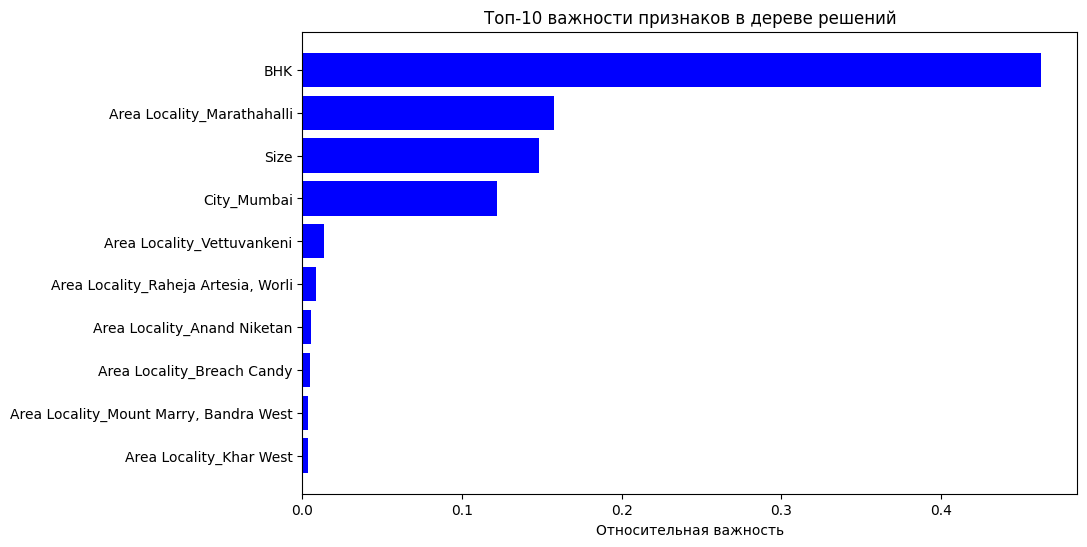

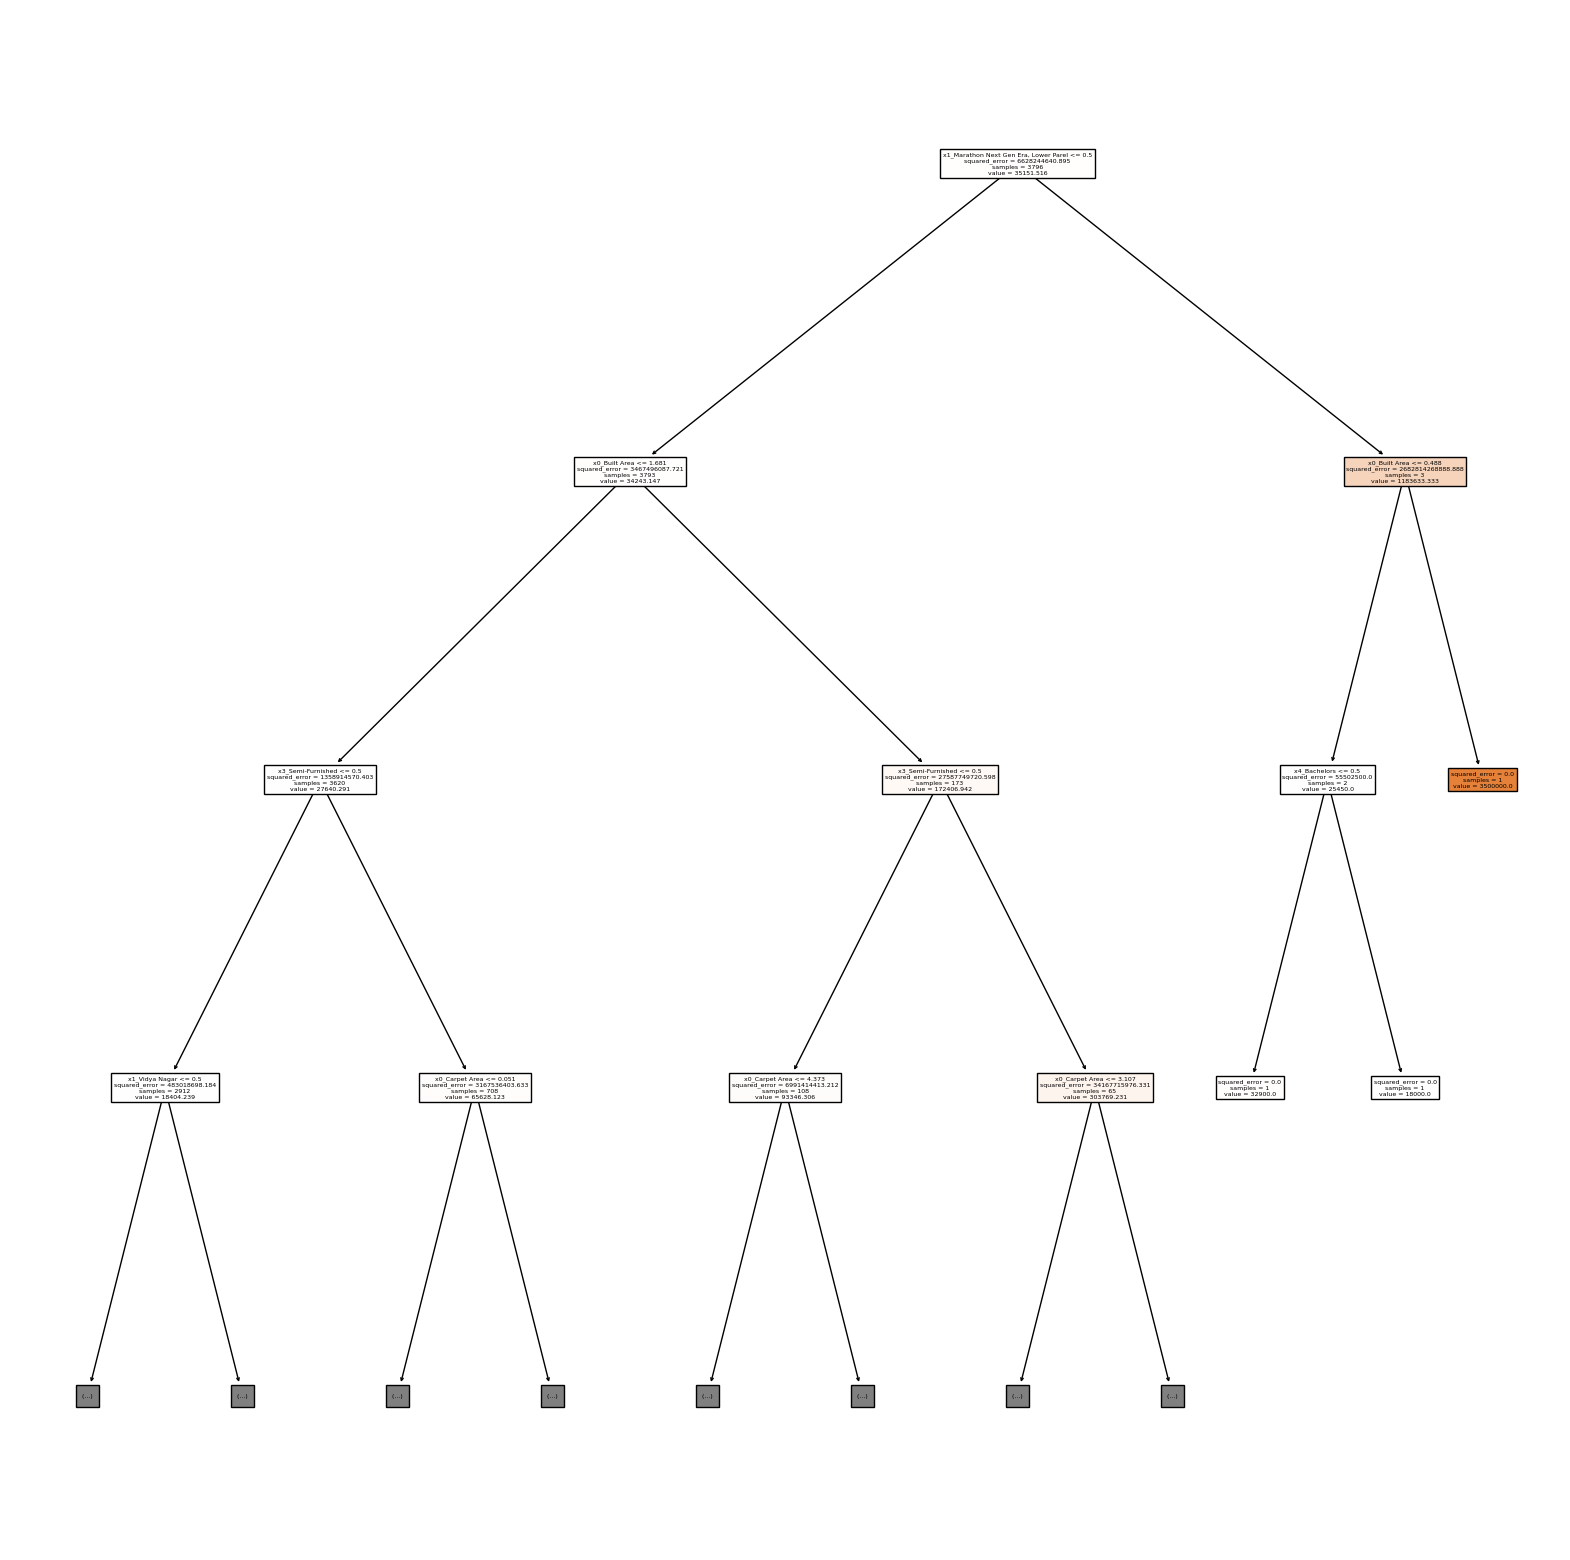

In [26]:
# Генерация изменённых названий признаков после преобразований
transformed_feature_names = (preprocessor
                             .transformers_[1][1]
                             .named_steps['encoder']
                             .get_feature_names_out(input_features=categorical_features))
all_feature_names = np.concatenate([numerical_features, transformed_feature_names])

# Визуализация важности признаков для дерева решений
importances = tree_model.named_steps['tree'].feature_importances_
indices = np.argsort(importances)[-10:]  # Топ-10 важных признаков

plt.figure(figsize=(10, 6))
plt.title('Топ-10 важности признаков в дереве решений')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
plt.xlabel('Относительная важность')
plt.show()

# Визуализация дерева решений
plt.figure(figsize=(20,20))
tree.plot_tree(tree_model.named_steps['tree'], feature_names=feature_names, max_depth=3, filled=True)
plt.show()